In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [ ]:
# --- PARAMÈTRES PHYSIQUES ET NUMÉRIQUES ---
nx, ny = 40, 40
Lx, Ly = 1.0, 1.0
dx, dy = Lx/nx, Ly/ny
Re = 100.0
Pr = 0.71
Ri = 1.0
U0 = 1.0  # Vitesse paroi supérieure
dt = 0.001
alpha_sor = 1.5
tol_sor = 1e-6

rho = 1.25  # Densité
Cp = 1005  # Capacité thermique

# --- INITIALISATION ---
T = np.zeros((nx, ny))
w = np.zeros((nx, ny))
psi = np.zeros((nx, ny))
T[0, :] = 1.0  # Paroi gauche chaude

# ----------------------------------------------------------------             
# ÉTAPE 0 : OUTILS (Thomas & Vitesses)
# ----------------------------------------------------------------

def solve_thomas(a, b, c, d):
    """Résout un système tridiagonal."""
    n = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for i in range(1, n):
        m = ac[i-1]/bc[i-1]
        bc[i] -= m*cc[i-1]
        dc[i] -= m*dc[i-1]
    x = np.zeros(n)
    x[-1] = dc[-1]/bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i]-cc[i]*x[i+1])/bc[i]
    return x

def get_velocity(psi):
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    u[:, 1:-1] = (psi[:, 2:] - psi[:, :-2]) / (2*dy)
    v[1:-1, :] = -(psi[2:, :] - psi[:-2, :]) / (2*dx)
    return u, v

# ----------------------------------------------------------------
# ÉTAPE 1 : RÉSOLUTION ÉNERGIE (ADI)
# ----------------------------------------------------------------

def solve_energy_adi(T, psi, dt, dx, dy, Re, Pr):
    u, v = get_velocity(psi)
    T_new = T.copy()
    diff_coeff = 1.0 / (Re * Pr)
    
    # Demi-pas 1 : Implicite en X, Explicite en Y
    for j in range(1, ny-1):
        a = np.full(nx-3, -dt/(2*dx**2) * diff_coeff)
        c = np.full(nx-3, -dt/(2*dx**2) * diff_coeff)
        b = np.full(nx-2, 1 + dt/(dx**2) * diff_coeff)
        
        # Termes explicites (Y) + Advection
        d = np.zeros(nx-2)
        for i in range(1, nx-1):
            adv = u[i,j]*(T[i+1,j]-T[i-1,j])/(2*dx) + v[i,j]*(T[i,j+1]-T[i,j-1])/(2*dy)
            diff_y = diff_coeff * (T[i,j+1] - 2*T[i,j] + T[i,j-1]) / dy**2
            d[i-1] = T[i,j] + dt/2 * (diff_y - adv)
        
        # Conditions aux limites (Dirichlet)
        d[0] -= a[0] * T[0,j]
        d[-1] -= c[-1] * T[-1,j]
        T_new[1:-1, j] = solve_thomas(a, b, c, d)
        
    # Demi-pas 2 : Implicite en Y, Explicite en X
    # (Logique similaire inversée à implémenter ici)
    return T_new

# ----------------------------------------------------------------
# ÉTAPE 2 : CALCUL DE W SUR LES FRONTIÈRES (Thom)
# ----------------------------------------------------------------

def update_vorticity_boundary(w, psi, dx, dy, U0):
    # Paroi Bas (y=0, psi=0)
    w[:, 0] = -2 * psi[:, 1] / dy**2
    # Paroi Haut (y=Ly, psi=0, u=U0)
    w[:, -1] = -2 * (psi[:, -2] + U0 * dy) / dy**2
    # Paroi Gauche (x=0, psi=0)
    w[0, :] = -2 * psi[1, :] / dx**2
    # Paroi Droite (x=Lx, psi=0)
    w[-1, :] = -2 * psi[-2, :] / dx**2
    return w

# ----------------------------------------------------------------
# ÉTAPE 3 : RÉSOLUTION W À L'INTÉRIEUR
# ----------------------------------------------------------------

def solve_vorticity_interior(w, T, psi, dt, dx, dy, Re, Ri):
    u, v = get_velocity(psi)
    w_new = w.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            adv = u[i,j]*(w[i+1,j]-w[i-1,j])/(2*dx) + v[i,j]*(w[i,j+1]-w[i,j-1])/(2*dy)
            diff = (1/Re) * ((w[i+1,j]-2*w[i,j]+w[i-1,j])/dx**2 + (w[i,j+1]-2*w[i,j]+w[i,j-1])/dy**2)
            buoyancy = Ri * (T[i+1,j] - T[i-1,j]) / (2*dx)
            w_new[i,j] = w[i,j] + dt * (-adv + diff + buoyancy)
    return w_new

# ----------------------------------------------------------------
# ÉTAPE 4 : RÉSOLUTION POISSON PSI (SOR)
# ----------------------------------------------------------------

def solve_poisson_psi(psi, w, dx, alpha_sor, tol):
    for _ in range(500): # Limite itérations
        psi_old = psi.copy()
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                target = 0.25 * (psi[i+1,j] + psi[i-1,j] + psi[i,j+1] + psi[i,j-1] + dx**2 * w[i,j])
                psi[i,j] = (1 - alpha_sor) * psi[i,j] + alpha_sor * target
        if np.linalg.norm(psi - psi_old) < tol:
            break
    return psi

# ----------------------------------------------------------------
# BOUCLE PRINCIPALE
# ----------------------------------------------------------------

img_dic = {'T': [], 'w': [], 'psi': []}

for n in range(201):
    T = solve_energy_adi(T, psi, dt, dx, dy, Re, Pr)
    w = update_vorticity_boundary(w, psi, dx, dy, U0)
    w = solve_vorticity_interior(w, T, psi, dt, dx, dy, Re, Ri)
    psi = solve_poisson_psi(psi, w, dx, alpha_sor, tol_sor)
    
    if n % 10 == 0:
        img_dic['T'].append(T.copy())
        img_dic['w'].append(w.copy())
        img_dic['psi'].append(psi.copy())


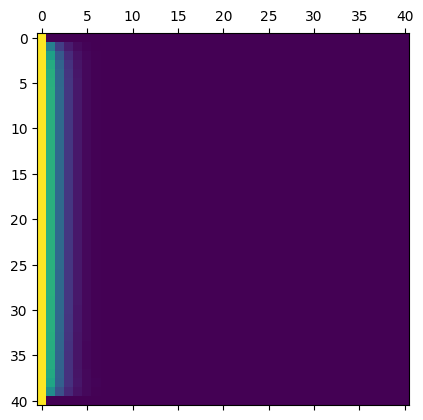

In [27]:
plt.matshow(img_dic['T'][-1].T, cmap=cm.viridis)